Using Goggle Colab Free version (T4-GPU) (to run all the part of code)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
np.random.seed(42)

---
Uploading dataset from kaggle : gowrishankarp/newspaper-text-summarization-cnn-dailymail
---

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d gowrishankarp/newspaper-text-summarization-cnn-dailymail

Dataset URL: https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail
License(s): CC0-1.0


In [5]:
!unzip newspaper-text-summarization-cnn-dailymail.zip -d data/

Archive:  newspaper-text-summarization-cnn-dailymail.zip
  inflating: data/cnn_dailymail/test.csv  
  inflating: data/cnn_dailymail/train.csv  
  inflating: data/cnn_dailymail/validation.csv  


In [ ]:
import os
for root, dirs, files in os.walk("data"):
    for file in files:
        print(os.path.join(root, file))

data/cnn_dailymail/train.csv
data/cnn_dailymail/validation.csv
data/cnn_dailymail/test.csv


In [6]:
import pandas as pd

train_df = pd.read_csv("data/cnn_dailymail/train.csv")

In [ ]:
train_df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
print(train_df.info())
print(valid_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287113 entries, 0 to 287112
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          287113 non-null  object
 1   article     287113 non-null  object
 2   highlights  287113 non-null  object
dtypes: object(3)
memory usage: 6.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13368 entries, 0 to 13367
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          13368 non-null  object
 1   article     13368 non-null  object
 2   highlights  13368 non-null  object
dtypes: object(3)
memory usage: 313.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11490 entries, 0 to 11489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11490 non-null  object
 1   article     11490 non-null  object
 2   highlights  

In [ ]:
print(train_df.iloc[0]["article"])
print(train_df.iloc[0]["highlights"])

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained b

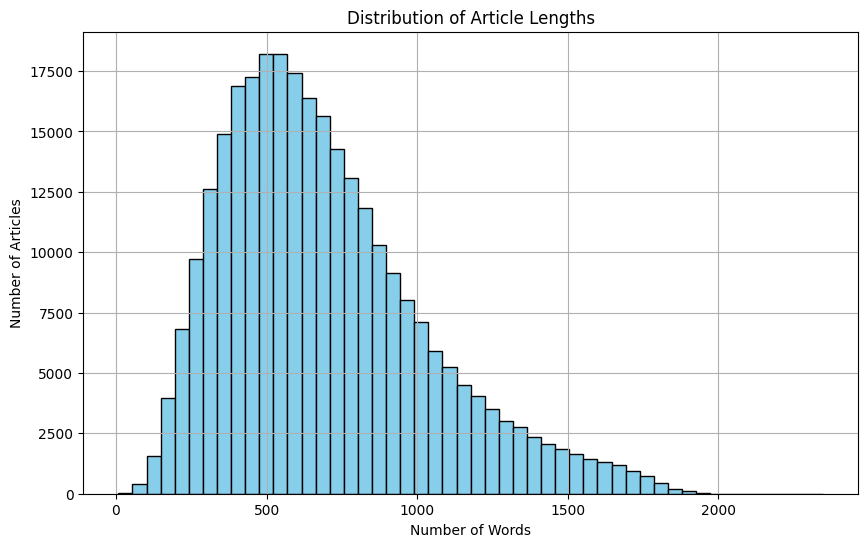

In [ ]:
article_lengths = train_df['article'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(article_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()


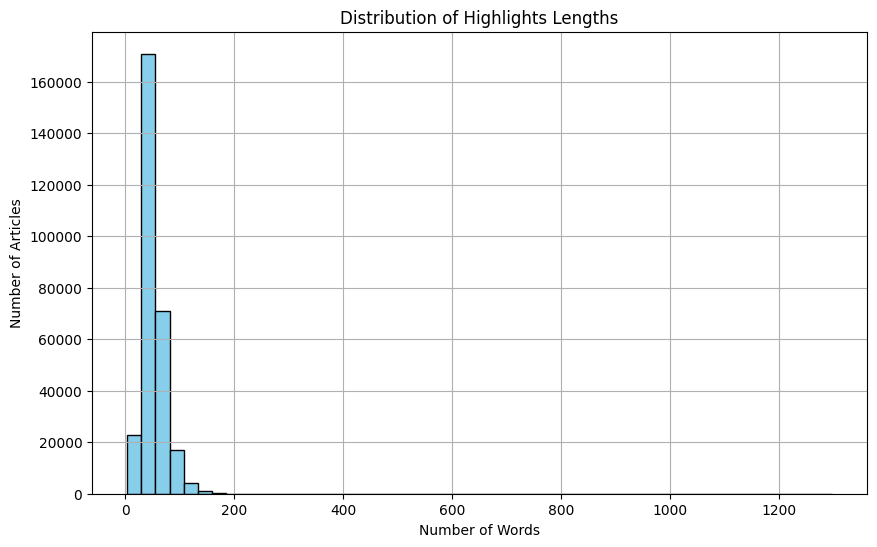

In [ ]:
highlights_lengths = train_df['highlights'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(highlights_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Highlights Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

In [ ]:
for i in range(10):
  print(train_df.iloc[i]["article"])

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained b

---
Preprocessing: removing unwanted words (keeping stopwords)
---

In [7]:
import re
contractions_map =  {
    "isn't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "i'm": "i am",
    "i've": "i have",
    "you've": "you have",
    "they're": "they are",
    "we're": "we are",
    "we've": "we have",
    "won't": "will not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "wasn't": "was not",
    "weren't": "were not",
    "there's": "there is",
    "that's": "that is",
    "what's": "what is",
    "who's": "who is",
    "let's": "let us",
    "mustn't": "must not",
    "shan't": "shall not",
}
def clean_text(raw_text):

    def expand_contractions(text, contractions_map):
        if not contractions_map:
            return text
        pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in contractions_map.keys()) + r')\b',
                             flags=re.IGNORECASE)
        return pattern.sub(lambda m: contractions_map.get(m.group(0).lower(), m.group(0)), text)

    # apply strop and lowering the text
    text = re.sub(r'\s+', ' ', raw_text).strip().lower()
    # make changes for short form words to full like isn't to is not
    text = expand_contractions(text, contractions_map)

    text = re.sub(r"\b(?!(" + "|".join(re.escape(k) for k in contractions_map) + r"))(\w+)'s\b", r"\2", text, flags=re.IGNORECASE)

    # remove published and updated words from the starting
    text = re.sub(r'By\s+.*?PUBLISHED:.*?UPDATED:.*?\.\s*', '', text, flags=re.IGNORECASE)

    # remove  "By . Associated Press . PUBLISHED"
    text = re.sub(r'By\s+\.?\s*[A-Za-z\s]*\.?\s*PUBLISHED:.*?UPDATED:.*?\.\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'^By\s+\.*\s*[a-z\s]+\.?\s*', '', text, flags=re.IGNORECASE)
    # remove date  and time stamp
    text = re.sub(r'\d{1,2}:\d{2}\s*[A-Z]{2,4},\s*\d{1,2}\s+\w+\s+\d{4}\s*\.', '', text,  flags=re.IGNORECASE)
    text = re.sub(r'\b(?:last\s+updated\s+at\s+)?\d{1,2}:\d{2}\s*[APap][Mm]\s+on\s+\d{1,2}(?:st|nd|rd|th)?\s+\w+\s+\d{4}\s*,?', '', text, flags=re.IGNORECASE)

    # if any part is there in brackets we don't consider it for highlights
    text = re.sub(r'\s*[\(\[].*?[\)\]]', '', text)

    # there were this words like video and read more which is unnecessary for highlight creation
    text = re.sub(r'scroll down for video.*?(?=\s[a-z])', '', text)
    text = re.sub(r'watch the video above.*?(?=\s[a-z])', '', text)
    text = re.sub(r'read more:.*?(?=\s[a-z])', '', text)

    # replace unnecessary punctuation marks like repetititve
    text = re.sub(r'--+', ' ', text)
    text = re.sub(r'[“”"]', '', text)
    text = re.sub(r"[^\w\s.,?!$£€₹\-']", '', text)

    # replace multiple commas and dots to single
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r',{2,}', ',', text)
    text = re.sub(r'^\.\s*', '', text)
    # remove whitespave from start and end
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
# this was done as to test
text = clean_text(train_df.iloc[13]["article"])
print(text)
print(train_df.iloc[13]["highlights"])
print(train_df.iloc[13]["article"])

louis van gaal said he had no option but to substitute paddy mcnair in the first half against southampton because the defender 'confidence' was shot - but believes that it will benefit the youngster in the long run. the 19-year-old was hooked by van gaal after only 39 minutes at st mary stadium on monday night during manchester united 2-1 victory over the saints. mcnair was struggling to contain southampton strikers shane long and graziano pelle, forcing van gaal into replacing him prematurely. paddy mcnair was substituted after only 39 minutes for manchester united against southampton . mcnair takes his seat in the stands having been replaced by his manager on monday night . united boss louis van gaal admitted he 'had to' substitute mcnair against southampton . mcnair shakes van gaal hand as he leaves the field having been replaced during united 2-1 victory . speaking to sky sports after the match, van gaal explained 'he had not any confidence. he had already given three big chances a

In [8]:
train_df["cleaned_article"] = train_df["article"].apply(clean_text)


In [ ]:
for i in range(30):
  print(train_df.iloc[i]["cleaned_article"])

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low, but officials feel it is important to alert people to the possible exposure. the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a. the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month. symptoms of hepatitis a include fever, tiredness, loss of appetite, nausea and abdominal dis

In [ ]:
for i in range(30):
  print(train_df.iloc[i]["cleaned_article"])

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low, but officials feel it is important to alert people to the possible exposure. the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a. the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month. symptoms of hepatitis a include fever, tiredness, loss of appetite, nausea and abdominal dis

In [ ]:
for i in range(30):
  print(train_df.iloc[i]["article"])

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained b

In [ ]:
for i in range(30):
  print(train_df.iloc[i]["cleaned_highlights"])

bishop john folda, of north dakota, is taking time off after being diagnosed . he contracted the infection through contaminated food in italy . church members in fargo, grand forks and jamestown could have been exposed .
criminal complaint cop used his role to help cocaine traffickers . ralph mata, an internal affairs lieutenant, allegedly helped group get guns . he also arranged to pay two assassins in a murder plot, a complaint alleges .
craig ecclestontodd, 27, had drunk at least three pints before driving car . was using phone when he veered across road in yarmouth, isle of wight . crashed headon into 28yearold rachel titleys car, who died in hospital . police say he would have been over legal drinkdrive limit at time of crash . he was found guilty at portsmouth crown court of causing death by dangerous driving .
nina dos santos says europe must be ready to accept sanctions will hurt both sides . targeting russias business community would be one way of sapping their support for pre

In [ ]:
for i in range(30):
  print(train_df.iloc[i]["highlights"])

Bishop John Folda, of North Dakota, is taking time off after being diagnosed .
He contracted the infection through contaminated food in Italy .
Church members in Fargo, Grand Forks and Jamestown could have been exposed .
Criminal complaint: Cop used his role to help cocaine traffickers .
Ralph Mata, an internal affairs lieutenant, allegedly helped group get guns .
He also arranged to pay two assassins in a murder plot, a complaint alleges .
Craig Eccleston-Todd, 27, had drunk at least three pints before driving car .
Was using phone when he veered across road in Yarmouth, Isle of Wight .
Crashed head-on into 28-year-old Rachel Titley's car, who died in hospital .
Police say he would have been over legal drink-drive limit at time of crash .
He was found guilty at Portsmouth Crown Court of causing death by dangerous driving .
Nina dos Santos says Europe must be ready to accept sanctions will hurt both sides .
Targeting Russia's business community would be one way of sapping their support

In [9]:
train_df["cleaned_highlights"] = train_df["highlights"].apply(clean_text)

---
EXTRACTIVE-SUMMARIZATION (basic idea was to apply tf-idf approach based on sentence score)
---

In [ ]:
# In tf-idf we don't require stopwords so we have removed it
import nltk
import os

custom_nltk_path = '/usr/local/nltk_data'
nltk.data.path.append(custom_nltk_path)

nltk.download('punkt', download_dir=custom_nltk_path)
nltk.download('stopwords', download_dir=custom_nltk_path)

[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/local/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('punkt', download_dir='/usr/local/nltk_data')

[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import os
nltk.data.path.append('/usr/local/nltk_data')

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import math
import string
from collections import defaultdict
nltk.download('stopwords')



stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

def clean_and_tokenize(text):
    # using punkt to have sentences from the context
    sentences = sent_tokenize(text, language='english')

    tokenized = []
    for sent in sentences:
        words = word_tokenize(sent.lower(), language='english')
        words = [w for w in words if w not in stop_words and w not in string.punctuation]
        tokenized.append(words)

    return sentences, tokenized

In [ ]:
def compute_tf(tokenized_sentences):
    tf = []
    for words in tokenized_sentences:
        tf_sent = defaultdict(float)
        for word in words:
            tf_sent[word] += 1
        for word in tf_sent:
            tf_sent[word] /= len(words)
        tf.append(tf_sent)
    return tf

In [ ]:
def compute_idf(tokenized_sentences):
    N = len(tokenized_sentences)
    idf = defaultdict(float)
    for words in tokenized_sentences:
        for word in set(words):
            idf[word] += 1

    for word in idf:
        idf[word] = math.log(N / (1 + idf[word]))

    return idf

In [ ]:
def score_sentences(tf, idf, original_sentences):
    sentence_scores = []
    for i, sent_tf in enumerate(tf):
        score = 0.0
        for word, tf_val in sent_tf.items():
            score += tf_val * idf.get(word, 0.0)
        sentence_scores.append((i, score))
    return sentence_scores

In [ ]:
def summarize(text, top_n=3):
    original_sentences, tokenized = clean_and_tokenize(text)
    tf = compute_tf(tokenized)
    idf = compute_idf(tokenized)
    scores = score_sentences(tf, idf, original_sentences)

    top_sentences = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]
    top_sentences = sorted(top_sentences)

    summary = [original_sentences[i] for i, _ in top_sentences]
    return " ".join(summary)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def summarize_sklearn(text, top_n=3):
    sentences = text.split(". ")
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(sentences)
    sentence_scores = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix).flatten()

    # If very short input, trim top_n
    top_n = min(top_n, len(sentences))
    top_indices = sentence_scores.argsort()[-top_n:][::-1]
    summary = [sentences[i] for i in sorted(top_indices)]
    return ". ".join(summary)

In [ ]:
text = train_df.iloc[0]["cleaned_article"]
summary = summarize_sklearn(text, top_n=2)
print(summary)
print(train_df.iloc[0]["cleaned_highlights"])

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a 
bishop john folda, of north dakota, is taking time off after being diagnosed . he contracted the infection through contaminated food in italy . church members in fargo, grand forks and jamestown could have been exposed .


In [ ]:
results = []
# used to observe the result with generated and truth highlights
for i in range(5):
    text = train_df.iloc[i]["cleaned_article"]
    summary = summarize_sklearn(text, top_n=2)
    highlights = train_df.iloc[i]["cleaned_highlights"]

    results.append({
        "Original Text": text,
        "Generated Summary": summary,
        "Actual Highlights": highlights
    })
comparison_df = pd.DataFrame(results)

from IPython.display import display
pd.set_option('display.max_colwidth', None)
display(comparison_df)

Original Text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda of the fargo catholic diocese in north 

---
ABSTRACTIVE-SUMMARIZATION
---
Encoder-Decoder model
Tried:
LSTM (with or without attention)
Transformers

In [10]:
# this range was selected as using higher values in colab was resulting into memory usage issue or we can't train the model because it's taking too much time to compute and train and resulted into runtime issue
article_mask = train_df["cleaned_article"].apply(lambda x: len(x.split()) <= 200)
highlight_mask = train_df["cleaned_highlights"].apply(lambda x: len(x.split()) <= 80)

# to take same index of article and highlight wrt to filter
combined_mask = article_mask & highlight_mask

# filtering baseed on combined_mask
filtered_articles = train_df.loc[combined_mask, "cleaned_article"]
filtered_highlights = train_df.loc[combined_mask, "cleaned_highlights"]


max_article_len = filtered_articles.apply(lambda x: len(x.split())).max()
print("Max article length (in words):", max_article_len)

max_highlight_len = filtered_highlights.apply(lambda x: len(x.split())).max()
print("Max highlight length (in words):", max_highlight_len)

Max article length (in words): 200
Max highlight length (in words): 80


In [ ]:
# this range was selected as using higher values in colab was resulting into memory usage issue or we can't train the model because it's taking too much time to compute and train and resulted into runtime issue
article_mask = train_df["cleaned_article"].apply(lambda x: len(x.split()) <= 300)
highlight_mask = train_df["cleaned_highlights"].apply(lambda x: len(x.split()) <= 150)

# to take same index of article and highlight wrt to filter
combined_mask = article_mask & highlight_mask

# filtering baseed on combined_mask
filtered_articles = train_df.loc[combined_mask, "cleaned_article"]
filtered_highlights = train_df.loc[combined_mask, "cleaned_highlights"]


max_article_len = filtered_articles.apply(lambda x: len(x.split())).max()
print("Max article length (in words):", max_article_len)

max_highlight_len = filtered_highlights.apply(lambda x: len(x.split())).max()
print("Max highlight length (in words):", max_highlight_len)

Max article length (in words): 300
Max highlight length (in words): 149


In [ ]:
print(filtered_highlights.iloc[495])
print(filtered_articles.iloc[495])

manchester city keen for sergio aguero to sign new deal with the club . premier league champions offered argentine £210,000-a-week contract . city also opened talks with vincent kompany, edin dzeko, joe hart and james milner .
manchester city hope sergio aguero will sign his new £210,000-a-week deal before the start of the new season. the premier league champions have made it clear to the argentina striker that he is pivotal to their future, along with captain vincent kompany, and talks have gone well. real madrid and barcelona have made no secret of their admiration for aguero, 26, but city want to wrap up a new improved five-year deal overtaking the current one which runs to 2017. video scroll down for lionel messi and sergio aguero play football tennis over fence . hopeful manchester city are keen for sergio aguero to sign a new deal before the start of the new season . aguero was dogged by niggling injuries last season, but still scored 28 goals in 34 games. city have opened initia

In [ ]:
print(filtered_articles[0])
print(filtered_highlights[0])

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low, but officials feel it is important to alert people to the possible exposure. the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a. the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month. symptoms of hepatitis a include fever, tiredness, loss of appetite, nausea and abdominal dis

In [11]:
# adding <sos> token as startseq and <eos> as endseq to the highlights
filtered_highlights = ["startseq " + highlights + " endseq" for highlights in filtered_highlights]

tokenizer = Tokenizer(oov_token="<OOV>")
context = pd.concat([filtered_articles, pd.Series(filtered_highlights)])
tokenizer.fit_on_texts(context)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"VOCAB SIZE: {VOCAB_SIZE}")
tokenized_articles = tokenizer.texts_to_sequences(filtered_articles)
tokenized_highlights = tokenizer.texts_to_sequences(filtered_highlights)


VOCAB SIZE: 45393


In [ ]:
# adding <sos> token as startseq and <eos> as endseq to the highlights for len 400
filtered_highlights = ["startseq " + highlights + " endseq" for highlights in filtered_highlights]

tokenizer = Tokenizer(oov_token="<OOV>")
context = pd.concat([filtered_articles, pd.Series(filtered_highlights)])
tokenizer.fit_on_texts(context)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"VOCAB SIZE: {VOCAB_SIZE}")
tokenized_articles = tokenizer.texts_to_sequences(filtered_articles)
tokenized_highlights = tokenizer.texts_to_sequences(filtered_highlights)


VOCAB SIZE: 106906


In [12]:
# using glove pre embedding as embedding with dim of 100 (suits the data and training computation)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

--2025-04-20 17:35:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-20 17:35:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-20 17:35:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [17]:
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
# preparing articles and highlights for training
max_len_articles = 200
max_len_highlights = 82

# padding and truncating both articles and highlights
padded_articles = pad_sequences(
    tokenized_articles,
    maxlen=max_len_articles,
    padding='post',
    truncating='post'
)

padded_highlights = pad_sequences(
    tokenized_highlights,
    maxlen=max_len_highlights,
    padding='post',
    truncating='post'
)
# creating decoder input and output data such that sentence current word is for input and next word for output
# input: <start> he is
# output: he is <end>
decoder_input_data = []
decoder_output_data = []

for seq in padded_highlights:
    decoder_input_data.append(seq[:-1])
    decoder_output_data.append(seq[1:])

decoder_input_data = np.array(decoder_input_data, dtype=np.int32)
decoder_output_data = np.array(decoder_output_data, dtype=np.int32)
decoder_target_data = np.expand_dims(decoder_output_data, -1)

encoder_input_data = np.array(padded_articles, dtype=np.int32)

print("Encoder Input Shape:", encoder_input_data.shape)
print("Decoder Input Shape:", decoder_input_data.shape)
print("Decoder Output Shape:", decoder_output_data.shape)

Encoder Input Shape: (7020, 200)
Decoder Input Shape: (7020, 81)
Decoder Output Shape: (7020, 81)


In [ ]:
# preparing articles and highlights for training
max_len_articles = 300
max_len_highlights = 151

# padding and truncating both articles and highlights
padded_articles = pad_sequences(
    tokenized_articles,
    maxlen=max_len_articles,
    padding='post',
    truncating='post'
)

padded_highlights = pad_sequences(
    tokenized_highlights,
    maxlen=max_len_highlights,
    padding='post',
    truncating='post'
)
# creating decoder input and output data such that sentence current word is for input and next word for output
# input: <start> he is
# output: he is <end>
decoder_input_data = []
decoder_output_data = []

for seq in padded_highlights:
    decoder_input_data.append(seq[:-1])
    decoder_output_data.append(seq[1:])

decoder_input_data = np.array(decoder_input_data, dtype=np.int32)
decoder_output_data = np.array(decoder_output_data, dtype=np.int32)
decoder_target_data = np.expand_dims(decoder_output_data, -1)

encoder_input_data = np.array(padded_articles, dtype=np.int32)

print("Encoder Input Shape:", encoder_input_data.shape)
print("Decoder Input Shape:", decoder_input_data.shape)
print("Decoder Output Shape:", decoder_output_data.shape)

Encoder Input Shape: (27026, 300)
Decoder Input Shape: (27026, 150)
Decoder Output Shape: (27026, 150)


Note: in the code - answers is related to highlight and question is related to article

In [18]:
# lstm with attention (with 1 layer)
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model

# Constants
HIDDEN_UNITS = 256
MAXLEN_ANSWERS = 81
MAXLEN_QUESTIONS = 200
embedding_dim = 100

def scaled_dot_product_attention(inputs):
    query, key, value = inputs
    d_k = tf.cast(tf.shape(key)[-1], tf.float32)
    score = tf.matmul(query, key, transpose_b=True)
    scaled_score = score / tf.math.sqrt(d_k)
    attention_weights = tf.nn.softmax(scaled_score, axis=-1)
    context_vector = tf.matmul(attention_weights, value)
    return context_vector

# Encoder
encoder_inputs = Input(shape=(MAXLEN_QUESTIONS,))
encoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(encoder_inputs)

encoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(MAXLEN_ANSWERS,))
decoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(decoder_inputs)

decoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention layer using Lambda
context_vector = Lambda(scaled_dot_product_attention)([decoder_outputs, encoder_outputs, encoder_outputs])

# Combine context and decoder output
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Final output
output = Dense(VOCAB_SIZE, activation='softmax')(decoder_combined_context)

# Define and compile model
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda_1' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 200, 100)  │  4,539,300 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 200)       │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 81, 100)   │  4,539,300 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 200,      │    365,568 │ embedding_6[0][0… │
│                     │ 256), (None,      │            │ not_equal_6[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 81, 256), │    365,568 │ embedding_7[0][0… │
│                     │ (None, 256),      │            │ lstm_6[0][1],     │
│                     │ (None, 256)]      │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 81)        │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 81, 256)   │          0 │ lstm_7[0][0],     │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ not_equal_7[0][0… │
│                     │                   │            │ not_equal_6[0][0… │
│                     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 81, 512)   │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 81, 45393) │ 23,286,609 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,096,345 (126.25 MB)

 Trainable params: 24,017,745 (91.62 MB)

 Non-trainable params: 9,078,600 (34.63 MB)

In [19]:
# using fastext and lstm with hidden units 256  with attention
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Training the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stop]
)


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 401ms/step - accuracy: 0.5446 - loss: 5.1647 - val_accuracy: 0.5833 - val_loss: 3.3738
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 421ms/step - accuracy: 0.5817 - loss: 3.2941 - val_accuracy: 0.5903 - val_loss: 3.2584
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 428ms/step - accuracy: 0.5872 - loss: 3.1475 - val_accuracy: 0.6044 - val_loss: 3.0997
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 414ms/step - accuracy: 0.6033 - loss: 2.9117 - val_accuracy: 0.6096 - val_loss: 2.9901
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 407ms/step - accuracy: 0.6050 - loss: 2.7705 - val_accuracy: 0.6148 - val_loss: 2.9111
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 409ms/step - accuracy: 0.6149 - loss: 2.5930 - val_accuracy: 0.6192 - val_loss: 2.8532
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 86s 435ms/step - accuracy: 0.6172 - loss: 2.4750 - val_accuracy: 0.6224 - val_loss: 2.8146
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 406ms/step - accuracy: 0.6210 - loss: 2

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
hidden_units = 256
def build_inference_models(model, hidden_units):
    # Encoder
    encoder_inputs = model.input[0]
    encoder_embedding_layer = model.get_layer("embedding_6")
    encoder_embedding = encoder_embedding_layer(encoder_inputs)
    encoder_lstm = model.get_layer("lstm_6")
    encoder_outputs, state_h_enc, state_c_enc = encoder_lstm(encoder_embedding)
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

    # Decoder Inputs
    decoder_inputs = Input(shape=(1,), name="decoder_input_infer")
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")
    encoder_outputs_input = Input(shape=(None, hidden_units), name="encoder_outputs_infer")

    # Decoder Embedding
    decoder_embedding_layer = model.get_layer("embedding_7")
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Decoder LSTM
    decoder_lstm = model.get_layer("lstm_7")
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # Attention (use Lambda for custom function)
    attention_lambda = model.get_layer("lambda_1")
    context_vector = attention_lambda([decoder_outputs, encoder_outputs_input, encoder_outputs_input])
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])


    # Dense Output
    decoder_dense = model.get_layer("dense_1")
    decoder_outputs_final = decoder_dense(decoder_combined_context)

    # Decoder Model
    decoder_model = Model(
        [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs_final, state_h_dec, state_c_dec]
    )

    return encoder_model, decoder_model

# Use the function
encoder_model, decoder_model = build_inference_models(model, hidden_units)


def decode_sequence(input_text, tokenizer, maxlen_questions, maxlen_answers, temperature=0.8):
    # input_seq = tokenizer.texts_to_sequences([input_text])
    # input_seq = pad_sequences(input_seq, maxlen=maxlen_questions, padding='post')
    input_seq = encoder_input_data[0].reshape(1, MAXLEN_QUESTIONS)  # shape = (1, 400)

    # Run encoder
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")
    target_seq = np.array([[start_token]])

    decoded_sentence = []

    for _ in range(maxlen_answers):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value
        )

        output_distribution = output_tokens[0, -1, :]
        #output_distribution = np.log(output_distribution + 1e-10) / temperature
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)


        sampled_token_index = np.argmax(output_distribution)
        #sampled_token_index = np.random.choice(len(output_distribution), p=output_distribution)

        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")

        if sampled_token_index == end_token or sampled_word == "?":
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return " ".join(decoded_sentence)

input_seq = encoder_input_data[0]
input = ""
for i in range(input_seq.shape[0]):
    input = input + tokenizer.index_word.get(input_seq[i], "<OOV>") + " "
print(input)
response = decode_sequence(input_seq, tokenizer, MAXLEN_QUESTIONS, MAXLEN_ANSWERS)
print("Bot:", response)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda_1' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a state immunization program manager molly howell says the risk is low but officials feel it is important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month symptoms of hepatitis a include fever tiredness loss of appetite nausea and abdominal discomfort fargo

In [ ]:
# LSTM WITH ATTENTION
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dot, Activation
from tensorflow.keras.models import Model

# Constants
HIDDEN_UNITS = 256
MAXLEN_ANSWERS = 150
MAXLEN_QUESTIONS = 300

# Encoder
encoder_inputs = Input(shape=(MAXLEN_QUESTIONS,))
encoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(encoder_inputs)

encoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(MAXLEN_ANSWERS,))
decoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(decoder_inputs)

decoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention
score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention_weights = Activation('softmax')(score)
context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs])

decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Final output layer
output = Dense(VOCAB_SIZE, activation='softmax')(decoder_combined_context)

# Define model
model = Model([encoder_inputs, decoder_inputs], output)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 300, 100)  │ 10,690,600 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 300)       │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 150, 100)  │ 10,690,600 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 300,      │    365,568 │ embedding_4[0][0… │
│                     │ 256), (None,      │            │ not_equal_4[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 150,      │    365,568 │ embedding_5[0][0… │
│                     │ 256), (None,      │            │ lstm_4[0][1],     │
│                     │ 256), (None,      │            │ lstm_4[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 150, 300)  │          0 │ lstm_5[0][0],     │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 150, 300)  │          0 │ dot_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 150, 256)  │          0 │ activation_2[0][… │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 150, 512)  │          0 │ dot_5[0][0],      │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 150,       │ 54,842,778 │ concatenate_4[0]… │
│                     │ 106906)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 76,955,114 (293.56 MB)

 Trainable params: 55,573,914 (212.00 MB)

 Non-trainable params: 21,381,200 (81.56 MB)

In [ ]:
# using fastext and lstm with hidden units 256  with attention
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Training the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stop]
)


Epoch 1/30
676/676 ━━━━━━━━━━━━━━━━━━━━ 1023s 2s/step - accuracy: 0.7461 - loss: 2.0794 - val_accuracy: 0.7615 - val_loss: 1.8511
Epoch 2/30
676/676 ━━━━━━━━━━━━━━━━━━━━ 1053s 2s/step - accuracy: 0.7624 - loss: 1.7797 - val_accuracy: 0.7714 - val_loss: 1.6822
Epoch 3/30
676/676 ━━━━━━━━━━━━━━━━━━━━ 1043s 2s/step - accuracy: 0.7711 - loss: 1.5947 - val_accuracy: 0.7769 - val_loss: 1.6026
Epoch 4/30
533/676 ━━━━━━━━━━━━━━━━━━━━ 3:09 1s/step - accuracy: 0.7764 - loss: 1.4718

KeyboardInterrupt: 

In [ ]:
# result from : '/content/chatbot_attention.keras'
hidden_units = 256
MAX_LEN_ANSWERS = 150
MAX_LEN_QUESTIONS = 400
def build_inference_models(model, hidden_units):
    # Encoder
    encoder_inputs = model.input[0]
    # Encoder Embedding
    encoder_embedding_layer = model.get_layer("embedding_4")
    encoder_embedding = encoder_embedding_layer(encoder_inputs)
    encoder_lstm = model.get_layer("lstm_4")
    encoder_outputs, state_h_enc, state_c_enc = encoder_lstm(encoder_embedding)
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

    # Decoder Inputs
    decoder_inputs = Input(shape=(1,), name="decoder_input_infer")
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")
    encoder_outputs_input = Input(shape=(None, hidden_units), name="encoder_outputs_infer")

    # Decoder Embedding
    decoder_embedding_layer = model.get_layer("embedding_5")
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Decoder LSTM
    decoder_lstm = model.get_layer("lstm_5")
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # Attention
    score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs_input])
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs_input])
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense Output
    decoder_dense = model.get_layer("dense_2")
    decoder_outputs_final = decoder_dense(decoder_combined_context)

    # Decoder Model
    decoder_model = Model(
        [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs_final, state_h_dec, state_c_dec]
    )

    return encoder_model, decoder_model
encoder_model, decoder_model = build_inference_models(model, hidden_units)


def decode_sequence(input_text, tokenizer, maxlen_questions, maxlen_answers, temperature=0.8):
    # input_seq = tokenizer.texts_to_sequences([input_text])
    # input_seq = pad_sequences(input_seq, maxlen=maxlen_questions, padding='post')
    input_seq = encoder_input_data[0].reshape(1, MAXLEN_QUESTIONS)

    # Run encoder
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")
    target_seq = np.array([[start_token]])

    decoded_sentence = []

    for _ in range(maxlen_answers):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value
        )

        output_distribution = output_tokens[0, -1, :]
        #output_distribution = np.log(output_distribution + 1e-10) / temperature
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)


        sampled_token_index = np.argmax(output_distribution)
        #sampled_token_index = np.random.choice(len(output_distribution), p=output_distribution)

        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")

        if sampled_token_index == end_token or sampled_word == "?":
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return " ".join(decoded_sentence)

input_seq = encoder_input_data[0]
input = ""
for i in range(input_seq.shape[0]):
    input = input + tokenizer.index_word.get(input_seq[i], "<OOV>") + " "
print(input)
response = decode_sequence(input_seq, tokenizer, MAXLEN_QUESTIONS, MAXLEN_ANSWERS)
print("Bot:", response)

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a state immunization program manager molly howell says the risk is low but officials feel it is important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month symptoms of hepatitis a include fever tiredness loss of appetite nausea and abdominal discomfort fargo

In [ ]:
print(model.input[0])

<KerasTensor shape=(None, 300), dtype=float32, sparse=False, name=keras_tensor_44>


In [ ]:
model.save("attention_summary_300.keras")

In [ ]:
# LSTM WITH ATTENTION
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dot, Activation
from tensorflow.keras.models import Model

# Constants
HIDDEN_UNITS = 256
MAXLEN_ANSWERS = 81
MAXLEN_QUESTIONS = 200

# Encoder
encoder_inputs = Input(shape=(MAXLEN_QUESTIONS,))
encoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(encoder_inputs)

encoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(MAXLEN_ANSWERS,))
decoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(decoder_inputs)

decoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention
score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention_weights = Activation('softmax')(score)
context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs])

decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Final output layer
output = Dense(VOCAB_SIZE, activation='softmax')(decoder_combined_context)

# Define model
model = Model([encoder_inputs, decoder_inputs], output)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 100)  │  4,539,300 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 81, 100)   │  4,539,300 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 200,      │    365,568 │ embedding[0][0],  │
│                     │ 256), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 81, 256), │    365,568 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 81, 200)   │          0 │ lstm_1[0][0],     │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 81, 200)   │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 81, 256)   │          0 │ activation[0][0], │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 81, 512)   │          0 │ dot_1[0][0],      │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 81, 45393) │ 23,286,609 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,096,345 (126.25 MB)

 Trainable params: 24,017,745 (91.62 MB)

 Non-trainable params: 9,078,600 (34.63 MB)

In [ ]:
# using fastext and lstm with hidden units 256  with attention
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Training the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stop]
)


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 68s 721ms/step - accuracy: 0.5278 - loss: 6.1384 - val_accuracy: 0.5755 - val_loss: 3.4099
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 68s 776ms/step - accuracy: 0.5725 - loss: 3.3812 - val_accuracy: 0.5835 - val_loss: 3.3725
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 744ms/step - accuracy: 0.5798 - loss: 3.2910 - val_accuracy: 0.5874 - val_loss: 3.3082
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 86s 796ms/step - accuracy: 0.5834 - loss: 3.1932 - val_accuracy: 0.5962 - val_loss: 3.1985
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 794ms/step - accuracy: 0.5960 - loss: 3.0290 - val_accuracy: 0.6040 - val_loss: 3.0956
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 78s 746ms/step - accuracy: 0.6004 - loss: 2.9125 - val_accuracy: 0.6071 - val_loss: 3.0193
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 86s 795ms/step - accuracy: 0.6043 - loss: 2.7981 - val_accuracy: 0.6111 - val_loss: 2.9602
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 65s 741ms/step - accuracy: 0.6067 - loss: 2.7033 - val_accu

In [ ]:
model1 = model

In [ ]:
# using fastext and lstm with hidden units 256  with attention
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Training the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stop]
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 71s 403ms/step - accuracy: 0.6504 - loss: 1.9725 - val_accuracy: 0.6297 - val_loss: 2.7779
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 70s 400ms/step - accuracy: 0.6618 - loss: 1.8734 - val_accuracy: 0.6317 - val_loss: 2.7815
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 382ms/step - accuracy: 0.6763 - loss: 1.7641 - val_accuracy: 0.6317 - val_loss: 2.7877
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 383ms/step - accuracy: 0.6841 - loss: 1.6890 - val_accuracy: 0.6326 - val_loss: 2.7983


In [ ]:
# result from : '/content/chatbot_attention.keras'
hidden_units = 256
MAX_LEN_ANSWERS = 81
MAX_LEN_QUESTIONS = 200
def build_inference_models(model, hidden_units):
    # Encoder
    encoder_inputs = model.input[0]
    encoder_outputs, state_h_enc, state_c_enc = model.get_layer("lstm").output
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

    # Decoder Inputs
    decoder_inputs = Input(shape=(1,), name="decoder_input_infer")
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")
    encoder_outputs_input = Input(shape=(None, hidden_units), name="encoder_outputs_infer")

    # Decoder Embedding
    decoder_embedding_layer = model.get_layer("embedding_1")
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Decoder LSTM
    decoder_lstm = model.get_layer("lstm_1")
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # Attention
    score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs_input])
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs_input])
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense Output
    decoder_dense = model.get_layer("dense")
    decoder_outputs_final = decoder_dense(decoder_combined_context)

    # Decoder Model
    decoder_model = Model(
        [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs_final, state_h_dec, state_c_dec]
    )

    return encoder_model, decoder_model
encoder_model, decoder_model = build_inference_models(model, hidden_units)


def decode_sequence(input_text, tokenizer, maxlen_questions, maxlen_answers, temperature=0.8):
    # input_seq = tokenizer.texts_to_sequences([input_text])
    # input_seq = pad_sequences(input_seq, maxlen=maxlen_questions, padding='post')
    input_seq = encoder_input_data[0].reshape(1, MAXLEN_QUESTIONS)  # shape = (1, 400)

    # Run encoder
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")
    target_seq = np.array([[start_token]])

    decoded_sentence = []

    for _ in range(maxlen_answers):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value
        )

        output_distribution = output_tokens[0, -1, :]
        #output_distribution = np.log(output_distribution + 1e-10) / temperature
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)


        sampled_token_index = np.argmax(output_distribution)
        #sampled_token_index = np.random.choice(len(output_distribution), p=output_distribution)

        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")

        if sampled_token_index == end_token or sampled_word == "?":
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return " ".join(decoded_sentence)

input_seq = encoder_input_data[0]
input = ""
for i in range(input_seq.shape[0]):
    input = input + tokenizer.index_word.get(input_seq[i], "<OOV>") + " "
print(input)
response = decode_sequence(input_seq, tokenizer, MAXLEN_QUESTIONS, MAXLEN_ANSWERS)
print("Bot:", response)

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a state immunization program manager molly howell says the risk is low but officials feel it is important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month symptoms of hepatitis a include fever tiredness loss of appetite nausea and abdominal discomfort fargo

In [ ]:
input = ""
for i in range(input_seq.shape[0]):
    input = input + tokenizer.index_word.get(input_seq[i], "<OOV>") + " "
print(input)
output_seq = decoder_input_data[0]
output = ""
for i in range(output_seq.shape[0]):
    output = output + tokenizer.index_word.get(output_seq[i], "<OOV>") + " "
print(output)
print(response)

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a state immunization program manager molly howell says the risk is low but officials feel it is important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month symptoms of hepatitis a include fever tiredness loss of appetite nausea and abdominal discomfort fargo

In [ ]:
model.save("summary-lstm-attention.keras")

In [ ]:
# transformer with 1 layer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, Dropout, Add, Layer
from tensorflow.keras import Model
import numpy as np

class CausalMaskLayer(Layer):
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        causal_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return causal_mask

def positional_encoding(length, depth):
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

def transformer_encoder(inputs, num_heads, ff_units, dropout_rate):
    # Self-Attention Layer
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=inputs.shape[-1]//num_heads)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = Add()([inputs, attention])
    attention = LayerNormalization()(attention)

    # Feed Forward Network
    ff = Dense(ff_units, activation='relu')(attention)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout_rate)(ff)
    ff = Add()([attention, ff])
    ff = LayerNormalization()(ff)
    return ff

def transformer_decoder(inputs, encoder_output, num_heads, ff_units, dropout_rate):
    # Create causal mask
    causal_mask = CausalMaskLayer()(inputs)

    # Self-Attention Layer
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=inputs.shape[-1]//num_heads)(
            inputs, inputs, attention_mask=causal_mask)
    attention = Dropout(dropout_rate)(attention)
    attention = Add()([inputs, attention])
    attention = LayerNormalization()(attention)

    # Cross-Attention Layer
    cross_attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=inputs.shape[-1]//num_heads)(
            attention, encoder_output)
    cross_attention = Dropout(dropout_rate)(cross_attention)
    cross_attention = Add()([attention, cross_attention])
    cross_attention = LayerNormalization()(cross_attention)

    # Feed Forward Network
    ff = Dense(ff_units, activation='relu')(cross_attention)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout_rate)(ff)
    ff = Add()([cross_attention, ff])
    ff = LayerNormalization()(ff)
    return ff

def transformer_model(
    input_vocab_size,
    output_vocab_size,
    input_length,
    output_length,
    embedding_matrix,
    embedding_dim=100,
    num_heads=6,
    ff_units=1200,
    dropout_rate=0.1
):
    # Inputs
    encoder_inputs = Input(shape=(input_length,))
    decoder_inputs = Input(shape=(output_length,))

    # Embedding layers using FastText
    encoder_embedding_layer = Embedding(
        input_dim=input_vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=input_length,
        trainable=False
    )

    decoder_embedding_layer = Embedding(
        input_dim=output_vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=output_length,
        trainable=False
    )

    encoder_embedding = encoder_embedding_layer(encoder_inputs)
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Positional Encoding
    encoder_pos_encoding = encoder_embedding + positional_encoding(input_length, embedding_dim)
    decoder_pos_encoding = decoder_embedding + positional_encoding(output_length, embedding_dim)

    # Transformer Encoder
    encoder_output = transformer_encoder(encoder_pos_encoding, num_heads, ff_units, dropout_rate)

    # Transformer Decoder
    decoder_output = transformer_decoder(decoder_pos_encoding, encoder_output, num_heads, ff_units, dropout_rate)

    # Output Layer
    output = Dense(output_vocab_size, activation='softmax')(decoder_output)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)
    return model


input_vocab_size = VOCAB_SIZE
output_vocab_size = VOCAB_SIZE
input_length = MAXLEN_QUESTIONS
output_length = MAXLEN_ANSWERS

model = transformer_model(input_vocab_size, output_vocab_size, input_length, output_length, embedding_matrix,)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 100)  │  4,539,300 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 100)  │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 100)  │     38,788 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 100)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 81, 100)   │  4,539,300 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 100)  │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 81, 100)   │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 100)  │        200 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ causal_mask_layer   │ (81, 81)          │          0 │ add_1[0][0]       │
│ (CausalMaskLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200, 1200) │    121,200 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 81, 100)   │     38,788 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0],      │
│                     │                   │            │ causal_mask_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200, 100)  │    120,100 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 81, 100)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 200, 100)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 81, 100)   │          0 │ add_1[0][0],      │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 100)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 81, 100)   │        200 │ add_4[0][0]     

 Total params: 14,263,257 (54.41 MB)

 Trainable params: 5,184,657 (19.78 MB)

 Non-trainable params: 9,078,600 (34.63 MB)

In [ ]:
# using transformer with one layer
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 30
VALIDATION_SPLIT = 0.2

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Training the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stop]
)

Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.5570 - loss: 5.4133 - val_accuracy: 0.6820 - val_loss: 2.5510
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.7149 - loss: 2.1735 - val_accuracy: 0.8188 - val_loss: 1.4221
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8394 - loss: 1.1679 - val_accuracy: 0.8921 - val_loss: 0.9134
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9084 - loss: 0.6688 - val_accuracy: 0.9258 - val_loss: 0.6957
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.9443 - loss: 0.3976 - val_accuracy: 0.9424 - val_loss: 0.5795
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9690 - loss: 0.2288 - val_accuracy: 0.9503 - val_loss: 0.5287
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9868 - loss: 0.1259 - val_accuracy: 0.9551 - val_loss: 0.5115
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9946 - loss: 0.0642 - 

In [ ]:
class TransformerInference:
    def __init__(self, model, tokenizer, max_length=97):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.start_token = tokenizer.word_index['startseq']
        self.end_token = tokenizer.word_index['endseq']
        self.inference_model = self._build_inference_model()

    def _build_inference_model(self):
        # Same encoder input
        encoder_inputs = Input(shape=(200,), name='encoder_input')

        # Variable-length decoder input
        decoder_inputs = Input(shape=(None,), name='decoder_input')

        # Reuse original model's layers
        encoder_embedding = self.model.get_layer('embedding_3')(encoder_inputs)
        decoder_embedding = self.model.get_layer('embedding_4')(decoder_inputs)


        # Positional encoding (modified to handle variable length)
        encoder_pos = encoder_embedding + positional_encoding(200, 100)

        # For decoder pos encoding
        def dynamic_pos_encoding(decoder_embedding):
            seq_len = tf.shape(decoder_embedding)[1]
            return decoder_embedding + positional_encoding(seq_len, 100)
        decoder_pos = tf.keras.layers.Lambda(
            dynamic_pos_encoding,
            output_shape=lambda input_shape: input_shape
        )(decoder_embedding)

        # Reuse encoder/decoder stacks
        encoder_output = transformer_encoder_stack(
            encoder_pos,

                num_heads=6,
                ff_units=1200,
                dropout_rate=0.1
        )

        decoder_output = transformer_decoder_stack(
            decoder_pos,
            encoder_output,

                num_heads=6,
                ff_units=1200,
                dropout_rate=0.1
        )

        output = self.model.get_layer('dense_5')(decoder_output)

        return Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)

    def encode_input(self, input_text):
        sequence = self.tokenizer.texts_to_sequences([input_text])[0]
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [sequence], maxlen=200, padding='post')
        return tf.convert_to_tensor(padded, dtype=tf.int32)

    def greedy_decode(self, encoder_input):
        batch_size = tf.shape(encoder_input)[0]
        decoder_input = tf.ones((batch_size, 1), dtype=tf.int32) * self.start_token

        finished = tf.zeros((batch_size,), dtype=tf.bool)

        for i in range(self.max_length - 1):
            predictions = self.inference_model([encoder_input, decoder_input], training=False)
            last_token_logits = predictions[:, -1, :]

            next_token = tf.argmax(last_token_logits, axis=-1, output_type=tf.int32)
            next_token = tf.expand_dims(next_token, axis=-1)

            decoder_input = tf.concat([decoder_input, next_token], axis=-1)

            finished |= tf.squeeze(next_token, axis=-1) == self.end_token
            if tf.reduce_all(finished):
                break

        sequences = decoder_input.numpy()
        results = []
        for seq in sequences:
            if self.end_token in seq:
                idx = list(seq).index(self.end_token)
                seq = seq[1:idx]
            else:
                seq = seq[1:]
            results.append(self.tokenizer.sequences_to_texts([seq])[0])
        return results

    def beam_search_decode(self, encoder_input, beam_width=3):
        batch_size = tf.shape(encoder_input)[0]

        beams = [
            (tf.ones((batch_size, 1), dtype=tf.int32) * self.start_token,
             0.0)
        ]

        for i in range(self.max_length - 1):
            new_beams = []
            for seq, score in beams:

                if seq[0, -1] == self.end_token:
                    new_beams.append((seq, score))
                    continue

                predictions = self.inference_model([encoder_input, seq], training=False)
                last_token = predictions[:, -1:, :]

                top_k = tf.math.top_k(last_token, k=beam_width)
                for j in range(beam_width):
                    token = top_k.indices[0, 0, j]
                    prob = top_k.values[0, 0, j]
                    new_seq = tf.concat([seq, tf.reshape([token], (1, 1))], axis=-1)
                    new_score = score - tf.math.log(prob + 1e-8)
                    new_beams.append((new_seq, new_score))

            beams = sorted(new_beams, key=lambda x: x[1])[:beam_width]

        return beams[0][0]

    def predict(self, input_text, method='greedy', beam_width=3):
        # input_seq = input_text
        # # input_seq = self.tokenizer.texts_to_sequences([input_text])
        # # input_seq = pad_sequences(input_seq, maxlen=97, padding='post')
        # """Main prediction method"""
        # encoder_input = self.encode_input(input_text)
        encoder_input =input_text
        if method == 'greedy':
            output = self.greedy_decode(encoder_input)
        elif method == 'beam':
            output = self.beam_search_decode(encoder_input, beam_width)
        else:
            raise ValueError("Method must be 'greedy' or 'beam'")

        return output[0]


In [ ]:
# transformer with 3 layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, Dropout, Add, Layer
from tensorflow.keras import Model
import numpy as np

# Positional Encoding
def positional_encoding(length, depth):
    depth = depth // 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

# Causal Mask Layer for decoder self-attention
class CausalMaskLayer(Layer):
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return tf.tile(tf.expand_dims(mask, 0), [batch_size, 1, 1])

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads, ff_units, dropout_rate):
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=inputs.shape[-1] // num_heads)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = Add()([inputs, attention])
    attention = LayerNormalization()(attention)

    ff = Dense(ff_units, activation='relu')(attention)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout_rate)(ff)
    ff = Add()([attention, ff])
    ff = LayerNormalization()(ff)
    return ff

# Transformer Decoder Block
def transformer_decoder(inputs, encoder_output, num_heads, ff_units, dropout_rate):
    causal_mask = CausalMaskLayer()(inputs)

    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=inputs.shape[-1] // num_heads)(
        inputs, inputs, attention_mask=causal_mask)
    attention = Dropout(dropout_rate)(attention)
    attention = Add()([inputs, attention])
    attention = LayerNormalization()(attention)

    cross_attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=inputs.shape[-1] // num_heads)(
        attention, encoder_output)
    cross_attention = Dropout(dropout_rate)(cross_attention)
    cross_attention = Add()([attention, cross_attention])
    cross_attention = LayerNormalization()(cross_attention)

    ff = Dense(ff_units, activation='relu')(cross_attention)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout_rate)(ff)
    ff = Add()([cross_attention, ff])
    ff = LayerNormalization()(ff)
    return ff

# Stack of Encoders
def transformer_encoder_stack(inputs, num_layers, num_heads, ff_units, dropout_rate):
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads, ff_units, dropout_rate)
    return x

# Stack of Decoders
def transformer_decoder_stack(inputs, encoder_output, num_layers, num_heads, ff_units, dropout_rate):
    x = inputs
    for _ in range(num_layers):
        x = transformer_decoder(x, encoder_output, num_heads, ff_units, dropout_rate)
    return x

# Main Transformer Model
def transformer_model(
    input_vocab_size,
    output_vocab_size,
    input_length,
    output_length,
    embedding_matrix,
    embedding_dim=300,
    num_layers=3,
    num_heads=6,
    ff_units=1248,
    dropout_rate=0.2
):
    encoder_inputs = Input(shape=(input_length,))
    decoder_inputs = Input(shape=(output_length,))

    encoder_embedding_layer = Embedding(
        input_dim=input_vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=input_length,
        trainable=False
    )

    decoder_embedding_layer = Embedding(
        input_dim=output_vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=output_length,
        trainable=False
    )

    encoder_embedding = encoder_embedding_layer(encoder_inputs)
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    encoder_pos_encoding = encoder_embedding + positional_encoding(input_length, embedding_dim)
    decoder_pos_encoding = decoder_embedding + positional_encoding(output_length, embedding_dim)

    encoder_output = transformer_encoder_stack(
        encoder_pos_encoding, num_layers, num_heads, ff_units, dropout_rate
    )

    decoder_output = transformer_decoder_stack(
        decoder_pos_encoding, encoder_output, num_layers, num_heads, ff_units, dropout_rate
    )

    output = Dense(output_vocab_size, activation='softmax')(decoder_output)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)
    return model

embedding_dim = 100

model = transformer_model(
    input_vocab_size=VOCAB_SIZE,
    output_vocab_size=VOCAB_SIZE,
    input_length=MAXLEN_QUESTIONS,
    output_length=MAX_LEN_ANSWERS,
    embedding_matrix=embedding_matrix,
    embedding_dim=embedding_dim
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 200, 100)  │  4,539,300 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 200, 100)  │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 100)  │     38,788 │ add_29[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_29[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 200, 100)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 200, 100)  │          0 │ add_29[0][0],     │
│                     │                   │            │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 100)  │        200 │ add_31[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 200, 1248) │    126,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 200, 100)  │    124,900 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 200, 100)  │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 200, 100)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 100)  │        200 │ add_32[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 100)  │     38,788 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 200, 100)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 200, 100)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 100)  │        200 │ add_33[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 200, 1248) │    126,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 200, 100)  │    124,900 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 15,521,073 (59.21 MB)

 Trainable params: 6,442,473 (24.58 MB)

 Non-trainable params: 9,078,600 (34.63 MB)

In [ ]:
# using transformer with one layer
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 30
VALIDATION_SPLIT = 0.2

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Training the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stop]
)

Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.5594 - loss: 5.4226 - val_accuracy: 0.6420 - val_loss: 2.6539
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - accuracy: 0.6821 - loss: 2.3449 - val_accuracy: 0.8050 - val_loss: 1.5191
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.8150 - loss: 1.3303 - val_accuracy: 0.8788 - val_loss: 0.9984
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8873 - loss: 0.8175 - val_accuracy: 0.9170 - val_loss: 0.7584
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9270 - loss: 0.5253 - val_accuracy: 0.9343 - val_loss: 0.6550
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9515 - loss: 0.3365 - val_accuracy: 0.9475 - val_loss: 0.5872
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9705 - loss: 0.2079 - val_accuracy: 0.9519 - val_loss: 0.5637
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9856 - loss: 0.1252 - 

In [ ]:
class TransformerInference:
    def __init__(self, model, tokenizer, max_length=97):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = 81
        self.start_token = tokenizer.word_index['startseq']
        self.end_token = tokenizer.word_index['endseq']
        self.inference_model = self._build_inference_model()

    def _build_inference_model(self):

        encoder_inputs = Input(shape=(200,), name='encoder_input')

        decoder_inputs = Input(shape=(None,), name='decoder_input')

        encoder_embedding = self.model.get_layer('embedding_7')(encoder_inputs)
        decoder_embedding = self.model.get_layer('embedding_8')(decoder_inputs)

        encoder_pos = encoder_embedding + positional_encoding(200, 100)

        def dynamic_pos_encoding(decoder_embedding):
            seq_len = tf.shape(decoder_embedding)[1]
            return decoder_embedding + positional_encoding(seq_len, 100)
        decoder_pos = tf.keras.layers.Lambda(
            dynamic_pos_encoding,
            output_shape=lambda input_shape: input_shape
        )(decoder_embedding)

        encoder_output = transformer_encoder_stack(
            encoder_pos,
             num_layers=3,
    num_heads=6,
    ff_units=1248,
    dropout_rate=0.2
        )

        decoder_output = transformer_decoder_stack(
            decoder_pos,
            encoder_output,
            num_layers=3,
    num_heads=6,
    ff_units=1248,
    dropout_rate=0.2
        )

        output = self.model.get_layer('dense_31')(decoder_output)

        return Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)

    def encode_input(self, input_text):
        sequence = self.tokenizer.texts_to_sequences([input_text])[0]
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [sequence], maxlen=200, padding='post')
        return tf.convert_to_tensor(padded, dtype=tf.int32)

    def greedy_decode(self, encoder_input):
        batch_size = tf.shape(encoder_input)[0]
        decoder_input = tf.ones((batch_size, 1), dtype=tf.int32) * self.start_token

        finished = tf.zeros((batch_size,), dtype=tf.bool)

        for i in range(self.max_length - 1):
            predictions = self.inference_model([encoder_input, decoder_input], training=False)
            last_token_logits = predictions[:, -1, :]

            next_token = tf.argmax(last_token_logits, axis=-1, output_type=tf.int32)
            next_token = tf.expand_dims(next_token, axis=-1)

            decoder_input = tf.concat([decoder_input, next_token], axis=-1)

            finished |= tf.squeeze(next_token, axis=-1) == self.end_token
            if tf.reduce_all(finished):
                break

        sequences = decoder_input.numpy()
        results = []
        for seq in sequences:
            if self.end_token in seq:
                idx = list(seq).index(self.end_token)
                seq = seq[1:idx]
            else:
                seq = seq[1:]
            results.append(self.tokenizer.sequences_to_texts([seq])[0])
        return results

    def beam_search_decode(self, encoder_input, beam_width=3):
        """Beam search decoding strategy"""
        batch_size = tf.shape(encoder_input)[0]

        beams = [
            (tf.ones((batch_size, 1), dtype=tf.int32) * self.start_token,
             0.0)
        ]

        for i in range(self.max_length - 1):
            new_beams = []
            for seq, score in beams:

                if seq[0, -1] == self.end_token:
                    new_beams.append((seq, score))
                    continue

                predictions = self.inference_model([encoder_input, seq], training=False)
                last_token = predictions[:, -1:, :]

                top_k = tf.math.top_k(last_token, k=beam_width)
                for j in range(beam_width):
                    token = top_k.indices[0, 0, j]
                    prob = top_k.values[0, 0, j]
                    new_seq = tf.concat([seq, tf.reshape([token], (1, 1))], axis=-1)
                    new_score = score - tf.math.log(prob + 1e-8)
                    new_beams.append((new_seq, new_score))

            beams = sorted(new_beams, key=lambda x: x[1])[:beam_width]

        return beams[0][0]

    def predict(self, input_text, method='greedy', beam_width=3):
        # input_seq = input_text
        # # input_seq = self.tokenizer.texts_to_sequences([input_text])
        # # input_seq = pad_sequences(input_seq, maxlen=97, padding='post')
        # """Main prediction method"""
        # encoder_input = self.encode_input(input_text)]
        input_text = tf.convert_to_tensor(encoder_input_data[0][None, :], dtype=tf.int32)
        encoder_input =input_text
        if method == 'greedy':
            output = self.greedy_decode(encoder_input)
        elif method == 'beam':
            output = self.beam_search_decode(encoder_input, beam_width)
        else:
            raise ValueError("Method must be 'greedy' or 'beam'")

        return output[0]
inference = TransformerInference(model, tokenizer)

# Make predictions
input_text = encoder_input_data[0]
output_greedy = inference.predict(input_text, method='greedy')
#output_beam = inference.predict(input_text, method='beam', beam_width=3)

print("Greedy:", output_greedy)
#print("Beam:", output_beam)

Greedy: pakistani government government government government government government warned israel thursday thursday thursday thursday monday monday monday monday thursday monday monday 11 11 11 over members other over over over over their their their their their their their their their their their their their their their their their their their their as as as as as clear whether whether what because because because because as as later later later because because because no no no no no no no no no


In [ ]:
model1.save("transformer_summary_one.keras")

In [ ]:
print(decoder_input_data[0])
print(decoder_output_data[0])

[   19  6042   379 19199     6   167  4330    10   417    60    80    28
   108  2912    17  5019     2  3327   165  4871   904     5   682  1684
   262     5  7722   815 14602     7 13086   114    23    33  3888    20
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[ 6042   379 19199     6   167  4330    10   417    60    80    28   108
  2912    17  5019     2  3327   165  4871   904     5   682  1684   262
     5  7722   815 14602     7 13086   114    23    33  3888    20     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0 

In [ ]:

# max_len_articles = 600
# max_len_highlights = 150
max_len_articles = 300
max_len_highlights = 150
# Truncate and pad both articles and highlights
padded_articles = pad_sequences(
    tokenized_articles,
    maxlen=max_len_articles,
    padding='post',
    truncating='post'
)

padded_highlights = pad_sequences(
    tokenized_highlights,
    maxlen=max_len_highlights,
    padding='post',
    truncating='post'
)
decoder_input_data = []
decoder_output_data = []

for seq in padded_highlights:
    decoder_input_data.append(seq[:-1])
    decoder_output_data.append(seq[1:])

decoder_input_data = np.array(decoder_input_data, dtype=np.int32)
decoder_output_data = np.array(decoder_output_data, dtype=np.int32)
decoder_target_data = np.expand_dims(decoder_output_data, -1)

encoder_input_data = np.array(padded_articles, dtype=np.int32)

print("Encoder Input Shape:", encoder_input_data.shape)
print("Decoder Input Shape:", decoder_input_data.shape)
print("Decoder Output Shape:", decoder_output_data.shape)

Encoder Input Shape: (7043, 300)
Decoder Input Shape: (7043, 149)
Decoder Output Shape: (7043, 149)


In [ ]:
print(decoder_input_data[0])
print(decoder_output_data[0])

[   21    18  6042   380 19199     6   169  4330    10   417    62    82
    30   110  2912    19  5019     2  3327   167  4871   904     5   682
  1684   264     5  7722   815 14602     7 13086   116    25    35  3888
    17    22     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
[   18  6042   380 19199     6   169  4330    10   417    62    82    30
   110  2912    19 

In [ ]:
print(decoder_input_data[0])
print(decoder_output_data[0])

[   19  6042   379 19199     6   167  4330    10   417    60    80    28
   108  2912    17  5019     2  3327   165  4871   904     5   682  1684
   262     5  7722   815 14602     7 13086   114    23    33  3888     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[ 6042   379 19199     6   167  4330    10   417    60    80    28   108
  2912    17  5019     2  3327   165  4871   904     5   682  1684   262
     5  7722   815 14602     7 13086   114    23    33  3888    20     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0 

In [ ]:
index_to_word = {index: word for word, index in tokenizer.word_index.items()}
index_to_word[0] = "<PAD>"

In [ ]:
decoded_input_words = [index_to_word.get(i, "<OOV>") for i in decoder_input_data[0]]
decoded_output_words = [index_to_word.get(i, "<OOV>") for i in decoder_output_data[0]]

print("Decoder Input:")
print(decoded_input_words)

print("\nDecoder Output:")
print(decoded_output_words)


Decoder Input:
['startseq', 'bishop', 'john', 'folda', 'of', 'north', 'dakota', 'is', 'taking', 'time', 'off', 'after', 'being', 'diagnosed', 'he', 'contracted', 'the', 'infection', 'through', 'contaminated', 'food', 'in', 'italy', 'church', 'members', 'in', 'fargo', 'grand', 'forks', 'and', 'jamestown', 'could', 'have', 'been', 'exposed', 'endseq', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Decoder Output:
['bishop', 'john', 'folda', 'of', 'north', 'dakota', 'is', 'taki

In [ ]:
subset_size = 500
encoder_input_small = encoder_input_data[:subset_size]
decoder_input_small = decoder_input_data[:subset_size]
decoder_output_small = decoder_output_data[:subset_size]
print("Encoder Input Shape:", encoder_input_small.shape)
print("Decoder Input Shape:", decoder_input_small.shape)
print("Decoder Output Shape:", decoder_output_small.shape)

Encoder Input Shape: (500, 600)
Decoder Input Shape: (500, 150)
Decoder Output Shape: (500, 150)


In [ ]:
# Truncate and pad both articles and highlights
padded_articles_val = pad_sequences(
    tokenized_articles_val,
    maxlen=max_len_articles,
    padding='post',
    truncating='post'
)

padded_highlights_val = pad_sequences(
    tokenized_highlights_val,
    maxlen=max_len_highlights,
    padding='post',
    truncating='post'
)
val_encoder_input_data = np.array(padded_articles_val, dtype=np.int32)
val_decoder_input_data = np.array(padded_highlights_val, dtype=np.int32)
val_decoder_output_data = np.array(padded_highlights_val, dtype=np.int32)
val_subset_size = 1000
val_encoder_input_small = val_encoder_input_data[:val_subset_size]
val_decoder_input_small = val_decoder_input_data[:val_subset_size]
val_decoder_output_small = val_decoder_output_data[:val_subset_size]
print("Encoder Input Shape:", val_encoder_input_small.shape)
print("Decoder Input Shape:", val_decoder_input_small.shape)
print("Decoder Output Shape:", val_decoder_output_small.shape)

Encoder Input Shape: (1000, 600)
Decoder Input Shape: (1000, 150)
Decoder Output Shape: (1000, 150)


In [ ]:
# LSTM WITH ATTENTION was done with 600 length words
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dot, Activation
from tensorflow.keras.models import Model

# Constants
HIDDEN_UNITS = 256
MAXLEN_ANSWERS = 199
MAXLEN_QUESTIONS = 400
# Encoder
encoder_inputs = Input(shape=(MAXLEN_QUESTIONS,))
encoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(encoder_inputs)

encoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(MAXLEN_ANSWERS,))
decoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(decoder_inputs)

decoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention
score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention_weights = Activation('softmax')(score)
context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs])

decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Final output layer
output = Dense(VOCAB_SIZE, activation='softmax')(decoder_combined_context)

# Define model
model = Model([encoder_inputs, decoder_inputs], output)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 199)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 400, 100)  │ 18,381,900 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 400)       │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 199, 100)  │ 18,381,900 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 400,      │    365,568 │ embedding_3[0][0… │
│                     │ 256), (None,      │            │ not_equal_4[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 199,      │    365,568 │ embedding_4[0][0… │
│                     │ 256), (None,      │            │ lstm_4[0][1],     │
│                     │ 256), (None,      │            │ lstm_4[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 199, 400)  │          0 │ lstm_5[0][0],     │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 199, 400)  │          0 │ dot_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 199, 256)  │          0 │ activation_1[0][… │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 199, 512)  │          0 │ dot_3[0][0],      │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 199,       │ 94,299,147 │ concatenate_2[0]… │
│                     │ 183819)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 131,794,083 (502.75 MB)

 Trainable params: 95,030,283 (362.51 MB)

 Non-trainable params: 36,763,800 (140.24 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=10,
    epochs=30,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/30
5329/5329 ━━━━━━━━━━━━━━━━━━━━ 4982s 935ms/step - accuracy: 0.8076 - loss: 1.5954 - val_accuracy: 0.8456 - val_loss: 1.1083
Epoch 2/30
5329/5329 ━━━━━━━━━━━━━━━━━━━━ 5026s 939ms/step - accuracy: 0.8552 - loss: 0.9904 - val_accuracy: 0.8679 - val_loss: 0.9323
Epoch 3/30
   7/5329 ━━━━━━━━━━━━━━━━━━━━ 1:17:16 871ms/step - accuracy: 0.8718 - loss: 0.8080

KeyboardInterrupt: 

In [ ]:
# result from : '/content/chatbot_attention.keras'
# was with above model trained
hidden_units = 256
MAX_LEN_ANSWERS = 199
MAX_LEN_QUESTIONS = 400
def build_inference_models(model, hidden_units):
    # Encoder
    encoder_inputs = model.input[0]
    encoder_outputs, state_h_enc, state_c_enc = model.get_layer("lstm_4").output
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

    # Decoder Inputs
    decoder_inputs = Input(shape=(1,), name="decoder_input_infer")
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")
    encoder_outputs_input = Input(shape=(None, hidden_units), name="encoder_outputs_infer")

    # Decoder Embedding
    decoder_embedding_layer = model.get_layer("embedding_3")
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Decoder LSTM
    decoder_lstm = model.get_layer("lstm_5")
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # Attention
    score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs_input])
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs_input])
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense Output
    decoder_dense = model.get_layer("dense_2")
    decoder_outputs_final = decoder_dense(decoder_combined_context)

    # Decoder Model
    decoder_model = Model(
        [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs_final, state_h_dec, state_c_dec]
    )

    return encoder_model, decoder_model
encoder_model, decoder_model = build_inference_models(model, hidden_units)


def decode_sequence(input_text, tokenizer, maxlen_questions, maxlen_answers, temperature=0.8):
    # input_seq = tokenizer.texts_to_sequences([input_text])
    # input_seq = pad_sequences(input_seq, maxlen=maxlen_questions, padding='post')
    input_seq = encoder_input_data[0].reshape(1, MAXLEN_QUESTIONS)  # shape = (1, 400)

    # Run encoder
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")
    target_seq = np.array([[start_token]])

    decoded_sentence = []

    for _ in range(maxlen_answers):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value
        )

        output_distribution = output_tokens[0, -1, :]
        #output_distribution = np.log(output_distribution + 1e-10) / temperature
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)


        sampled_token_index = np.argmax(output_distribution)
        #sampled_token_index = np.random.choice(len(output_distribution), p=output_distribution)

        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")

        if sampled_token_index == end_token or sampled_word == "?":
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return " ".join(decoded_sentence)

input_seq = encoder_input_data[0]
input = ""
for i in range(input_seq.shape[0]):
    input = input + index_to_word.get(input_seq[i], "<OOV>") + " "
print(input)
response = decode_sequence(input_seq, tokenizer, MAXLEN_QUESTIONS, MAXLEN_ANSWERS)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━

In [ ]:
input = ""
for i in range(input_seq.shape[0]):
    input = input + tokenizer.index_word.get(input_seq[i], "<OOV>") + " "
print(input)
output_seq = decoder_input_data[0]
output = ""
for i in range(output_seq.shape[0]):
    output = output + tokenizer.index_word.get(output_seq[i], "<OOV>") + " "
print(output)
print(response)


the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a state immunization program manager molly howell says the risk is low but officials feel it is important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month symptoms of hepatitis a include fever tiredness loss of appetite nausea and abdominal discomfort fargo

In [ ]:
model.save("summary_lstm.keras")

In [ ]:
#model.save("summary_lstm_attent_preem.keras")
# LSTM WITH ATTENTION
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dot, Activation
from tensorflow.keras.models import Model

# Constants
HIDDEN_UNITS = 256
MAXLEN_ANSWERS = 81
MAXLEN_QUESTIONS = 200
# Encoder
encoder_inputs = Input(shape=(MAXLEN_QUESTIONS,))
encoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(encoder_inputs)

encoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(MAXLEN_ANSWERS,))
decoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(decoder_inputs)

decoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention
score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])  # shape: (batch_size, dec_seq_len, enc_seq_len)
attention_weights = Activation('softmax')(score)
context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs])  # shape: (batch_size, dec_seq_len, hidden)

decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Final output layer
output = Dense(VOCAB_SIZE, activation='softmax')(decoder_combined_context)

# Define model
model = Model([encoder_inputs, decoder_inputs], output)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 200, 100)  │  4,539,300 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_17        │ (None, 200)       │          0 │ input_layer_10[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 81, 100)   │  4,539,300 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 200,      │    365,568 │ embedding_8[0][0… │
│                     │ 256), (None,      │            │ not_equal_17[0][… │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 81, 256), │    365,568 │ embedding_9[0][0… │
│                     │ (None, 256),      │            │ lstm_9[0][1],     │
│                     │ (None, 256)]      │            │ lstm_9[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 81, 200)   │          0 │ lstm_10[0][0],    │
│                     │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 81, 200)   │          0 │ dot_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 81, 256)   │          0 │ activation_1[0][… │
│                     │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 81, 512)   │          0 │ dot_3[0][0],      │
│ (Concatenate)       │                   │            │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 81, 45393) │ 23,286,609 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,096,345 (126.25 MB)

 Trainable params: 24,017,745 (91.62 MB)

 Non-trainable params: 9,078,600 (34.63 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=8,
    epochs=30,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 96s 117ms/step - accuracy: 0.5676 - loss: 4.0063 - val_accuracy: 0.6122 - val_loss: 3.0107
Epoch 2/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 140s 114ms/step - accuracy: 0.6034 - loss: 2.9277 - val_accuracy: 0.6268 - val_loss: 2.7774
Epoch 3/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.6181 - loss: 2.5741 - val_accuracy: 0.6339 - val_loss: 2.6715
Epoch 4/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.6295 - loss: 2.2816 - val_accuracy: 0.6381 - val_loss: 2.6243
Epoch 5/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 143s 115ms/step - accuracy: 0.6440 - loss: 2.0216 - val_accuracy: 0.6422 - val_loss: 2.6164
Epoch 6/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.6670 - loss: 1.7920 - val_accuracy: 0.6434 - val_loss: 2.6232
Epoch 7/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 142s 113ms/step - accuracy: 0.6950 - loss: 1.5820 - val_accuracy: 0.6452 - val_loss: 2.6487
Epoch 8/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 144s 116ms/step - accuracy: 0.7170 - 

In [ ]:
# result from : '/content/chatbot_attention.keras'
# was with above model trained
hidden_units = 256
MAX_LEN_ANSWERS = 81
MAX_LEN_QUESTIONS = 200
def build_inference_models(model, hidden_units):
    # Encoder
    encoder_inputs = model.input[0]
    encoder_outputs, state_h_enc, state_c_enc = model.get_layer("lstm_9").output
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

    # Decoder Inputs
    decoder_inputs = Input(shape=(1,), name="decoder_input_infer")
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")
    encoder_outputs_input = Input(shape=(None, hidden_units), name="encoder_outputs_infer")

    # Decoder Embedding
    decoder_embedding_layer = model.get_layer("embedding_8")
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Decoder LSTM
    decoder_lstm = model.get_layer("lstm_10")
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # Attention
    score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs_input])
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs_input])
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense Output
    decoder_dense = model.get_layer("dense_4")
    decoder_outputs_final = decoder_dense(decoder_combined_context)

    # Decoder Model
    decoder_model = Model(
        [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs_final, state_h_dec, state_c_dec]
    )

    return encoder_model, decoder_model
encoder_model, decoder_model = build_inference_models(model, hidden_units)


def decode_sequence(input_text, tokenizer, maxlen_questions, maxlen_answers, temperature=0.8):
    # input_seq = tokenizer.texts_to_sequences([input_text])
    # input_seq = pad_sequences(input_seq, maxlen=maxlen_questions, padding='post')
    input_seq = encoder_input_data[0].reshape(1, MAXLEN_QUESTIONS)  # shape = (1, 400)

    # Run encoder
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")
    target_seq = np.array([[start_token]])

    decoded_sentence = []

    for _ in range(maxlen_answers):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value
        )

        output_distribution = output_tokens[0, -1, :]
        #output_distribution = np.log(output_distribution + 1e-10) / temperature
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)


        sampled_token_index = np.argmax(output_distribution)
        #sampled_token_index = np.random.choice(len(output_distribution), p=output_distribution)

        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")

        if sampled_token_index == end_token or sampled_word == "?":
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return " ".join(decoded_sentence)

input_seq = encoder_input_data[0]
input = ""
for i in range(input_seq.shape[0]):
    input = input + tokenizer.index_word.get(input_seq[i], "<OOV>") + " "
print(input)
response = decode_sequence(input_seq, tokenizer, MAXLEN_QUESTIONS, MAXLEN_ANSWERS)
print("Bot:", response)

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a state immunization program manager molly howell says the risk is low but officials feel it is important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month symptoms of hepatitis a include fever tiredness loss of appetite nausea and abdominal discomfort fargo

In [ ]:
model.save("summary_lstm_attent_preem.keras")

In [ ]:
# LSTM WITH LEARNABLE dot scaled ATTENTION
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dot, Activation, TimeDistributed
from tensorflow.keras.models import Model

# Constants
HIDDEN_UNITS = 256
MAXLEN_ANSWERS = 81
MAXLEN_QUESTIONS = 200

# Encoder
encoder_inputs = Input(shape=(MAXLEN_QUESTIONS,))
encoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],

    trainable=False
)(encoder_inputs)

encoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(MAXLEN_ANSWERS,))
decoder_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=embedding_dim,
    weights=[embedding_matrix],

    trainable=False
)(decoder_inputs)

decoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

query_layer = Dense(HIDDEN_UNITS)
key_layer = Dense(HIDDEN_UNITS)
value_layer = Dense(HIDDEN_UNITS)

Q = query_layer(decoder_outputs)
K = key_layer(encoder_outputs)
V = value_layer(encoder_outputs)

# Scaled dot-product attention
score = Dot(axes=[2, 2])([Q, K])
attention_weights = Activation('softmax')(score)

context_vector = Dot(axes=[2, 1])([attention_weights, V])

# Combine context with decoder output
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Final output layer
output = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))(decoder_combined_context)

# Define model
model = Model([encoder_inputs, decoder_inputs], output)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 200, 100)  │  4,539,300 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 81, 100)   │  4,539,300 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 200,      │    365,568 │ embedding_12[0][… │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 81, 256), │    365,568 │ embedding_13[0][… │
│                     │ (None, 256),      │            │ lstm_13[0][1],    │
│                     │ (None, 256)]      │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 81, 256)   │     65,792 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 200, 256)  │     65,792 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_8 (Dot)         │ (None, 81, 200)   │          0 │ dense_9[0][0],    │
│                     │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 81, 200)   │          0 │ dot_8[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 200, 256)  │     65,792 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_9 (Dot)         │ (None, 81, 256)   │          0 │ activation_4[0][… │
│                     │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 81, 512)   │          0 │ dot_9[0][0],      │
│ (Concatenate)       │                   │            │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 81, 45393) │ 23,286,609 │ concatenate_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,293,721 (127.01 MB)

 Trainable params: 24,215,121 (92.37 MB)

 Non-trainable params: 9,078,600 (34.63 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=8,
    epochs=30,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 258s 291ms/step - accuracy: 0.5643 - loss: 4.0975 - val_accuracy: 0.6103 - val_loss: 3.0342
Epoch 2/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 260s 291ms/step - accuracy: 0.6034 - loss: 2.9358 - val_accuracy: 0.6242 - val_loss: 2.8247
Epoch 3/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 260s 289ms/step - accuracy: 0.6165 - loss: 2.5687 - val_accuracy: 0.6302 - val_loss: 2.7430
Epoch 4/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 261s 289ms/step - accuracy: 0.6233 - loss: 2.2852 - val_accuracy: 0.6344 - val_loss: 2.7160
Epoch 5/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 264s 291ms/step - accuracy: 0.6468 - loss: 1.9875 - val_accuracy: 0.6365 - val_loss: 2.7253
Epoch 6/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 262s 292ms/step - accuracy: 0.6684 - loss: 1.7831 - val_accuracy: 0.6382 - val_loss: 2.7312
Epoch 7/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 262s 291ms/step - accuracy: 0.6863 - loss: 1.6337 - val_accuracy: 0.6372 - val_loss: 2.7629


In [ ]:
def build_inference_models(model, hidden_units):
    # Encoder
    encoder_inputs = model.input[0]  # input_1
    encoder_embedding = model.get_layer(index=1)(encoder_inputs)  # embedding_1 (encoder embedding)
    encoder_lstm = model.get_layer(index=2)  # lstm
    encoder_outputs, state_h_enc, state_c_enc = encoder_lstm(encoder_embedding)
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

    # Decoder Inputs
    decoder_inputs = Input(shape=(1,), name="decoder_input_infer")  # one timestep
    encoder_outputs_input = Input(shape=(MAXLEN_QUESTIONS, hidden_units), name="encoder_outputs_infer")
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")

    # Decoder Embedding
    decoder_embedding_layer = model.get_layer(index=3)  # embedding_2
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Decoder LSTM
    decoder_lstm = model.get_layer(index=4)
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # Learnable Q-K-V projections
    query_layer = model.get_layer(index=5)
    key_layer = model.get_layer(index=6)
    value_layer = model.get_layer(index=7)

    Q = query_layer(decoder_outputs)
    K = key_layer(encoder_outputs_input)
    V = value_layer(encoder_outputs_input)

    score = Dot(axes=[2, 2])([Q, K])
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([attention_weights, V])
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Output layer
    output_layer = model.get_layer(index=8)
    decoder_outputs_final = output_layer(decoder_combined_context)

    decoder_model = Model(
        [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs_final, state_h_dec, state_c_dec]
    )

    return encoder_model, decoder_model
def decode_sequence(input_text, tokenizer, maxlen_questions, maxlen_answers, temperature=1.0):
    # input_seq = tokenizer.texts_to_sequences([input_text])
    # input_seq = pad_sequences(input_seq, maxlen=maxlen_questions, padding='post')

    encoder_outputs, state_h, state_c = encoder_model.predict(np.array([input_seq]))
    states_value = [state_h, state_c]

    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")
    target_seq = np.array([[start_token]])

    decoded_sentence = []

    for _ in range(maxlen_answers):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value
        )

        output_distribution = output_tokens[0, -1, :]
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)

        sampled_token_index = np.argmax(output_distribution)
        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")

        if sampled_token_index == end_token or sampled_word == "?":
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return " ".join(decoded_sentence)
input_seq = encoder_input_data[0]
input = ""
for i in range(input_seq.shape[0]):
    input = input + tokenizer.index_word.get(input_seq[i], "<OOV>") + " "
print(input)
response = decode_sequence(input_seq, tokenizer, 200, 81)
print("Bot:", response)


the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a state immunization program manager molly howell says the risk is low but officials feel it is important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month symptoms of hepatitis a include fever tiredness loss of appetite nausea and abdominal discomfort fargo

In [ ]:
# lstm using keras embedding layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

# Hypothetical values
vocab_size = VOCAB_SIZE
embedding_dim = 100
latent_dim = 256
max_len_highlights = 81
#  Inputs
encoder_inputs = Input(shape=(max_len_articles,))
decoder_inputs = Input(shape=(max_len_highlights,))

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)
enc_emb = embedding_layer(encoder_inputs)
dec_emb = embedding_layer(decoder_inputs)

# Encoder LSTM
encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Output layer: softmax over vocab
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Prepare decoder output as categorical
decoder_target_data = np.expand_dims(decoder_output_data, -1)
# val_decoder_target_data = np.expand_dims(val_decoder_output_small, -1)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 81, 100)   │  4,539,300 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 200)       │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 256),     │    365,568 │ embedding_3[0][0… │
│                     │ (None, 256),      │            │ not_equal_6[0][0] │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 81, 256), │    365,568 │ embedding_3[1][0… │
│                     │ (None, 256),      │            │ lstm_5[0][1],     │
│                     │ (None, 256)]      │            │ lstm_5[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 81, 45393) │ 11,666,001 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,936,437 (64.61 MB)

 Trainable params: 12,397,137 (47.29 MB)

 Non-trainable params: 4,539,300 (17.32 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=8,
    epochs=30,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - loss: 7.9158 - val_loss: 6.9981
Epoch 2/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - loss: 6.6701 - val_loss: 6.5329
Epoch 3/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - loss: 6.0400 - val_loss: 6.2952
Epoch 4/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - loss: 5.5893 - val_loss: 6.1751
Epoch 5/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - loss: 5.2089 - val_loss: 6.1244
Epoch 6/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - loss: 4.8599 - val_loss: 6.1103
Epoch 7/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 81s 55ms/step - loss: 4.5552 - val_loss: 6.1204
Epoch 8/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 83s 56ms/step - loss: 4.2709 - val_loss: 6.1562
Epoch 9/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 83s 58ms/step - loss: 4.0122 - val_loss: 6.2009


In [ ]:
# result from : '/content/chatbot_attention.keras'
# was with above model trained
hidden_units = 256
MAX_LEN_ANSWERS = 81
MAX_LEN_QUESTIONS = 200
MAXLEN_QUESTIONS = 200
MAXLEN_ANSWERS = 81
def build_inference_models(model, hidden_units):
    # Encoder
    encoder_inputs = model.input[0]
    encoder_outputs, state_h_enc, state_c_enc = model.get_layer("lstm_5").output
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

    # Decoder Inputs
    decoder_inputs = Input(shape=(1,), name="decoder_input_infer")
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")
    encoder_outputs_input = Input(shape=(None, hidden_units), name="encoder_outputs_infer")

    # Decoder Embedding
    decoder_embedding_layer = model.get_layer("embedding_3")
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Decoder LSTM
    decoder_lstm = model.get_layer("lstm_6")
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )


    decoder_dense = model.get_layer("dense_2")
    decoder_outputs_final = decoder_dense(decoder_outputs)

    # Decoder Model
    decoder_model = Model(
        [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs_final, state_h_dec, state_c_dec]
    )

    return encoder_model, decoder_model
encoder_model, decoder_model = build_inference_models(model, hidden_units)


def decode_sequence(input_text, tokenizer, maxlen_questions, maxlen_answers, temperature=0.8):
    input_seq = encoder_input_data[0].reshape(1, MAXLEN_QUESTIONS)

    # Run encoder
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)

    # For the decoder, we need to reshape encoder output to match the shape (1, 1, hidden_units)
    encoder_outputs = np.expand_dims(encoder_outputs, axis=1)

    states_value = [state_h, state_c]

    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")
    target_seq = np.array([[start_token]])

    decoded_sentence = []

    for _ in range(maxlen_answers):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value
        )

        output_distribution = output_tokens[0, -1, :]
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)

        sampled_token_index = np.argmax(output_distribution)

        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")

        if sampled_token_index == end_token or sampled_word == "?":
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return " ".join(decoded_sentence)

input_seq = encoder_input_data[0]
input = ""
for i in range(input_seq.shape[0]):
    input = input + tokenizer.index_word.get(input_seq[i], "<OOV>") + " "
print(input)
response = decode_sequence(input_seq, tokenizer, 200, 81)
print("Bot:", response)


the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a virus in late september and early october the state health department has issued an advisory of exposure for anyone who attended five churches and took communion bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo grand forks and jamestown to the hepatitis a state immunization program manager molly howell says the risk is low but officials feel it is important to alert people to the possible exposure the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month symptoms of hepatitis a include fever tiredness loss of appetite nausea and abdominal discomfort fargo

In [ ]:
model.save("summary_lstm_preembe.keras")

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

# Hypothetical values
vocab_size = VOCAB_SIZE  # Replace with your actual vocab size
embedding_dim = 100
latent_dim = 256
max_len_highlights = max_len_highlights-1
# Inputs
encoder_inputs = Input(shape=(max_len_articles,))
decoder_inputs = Input(shape=(max_len_highlights,))

# Shared Embedding layer (optional: pre-trained embeddings here)
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)

enc_emb = embedding_layer(encoder_inputs)
dec_emb = embedding_layer(decoder_inputs)

# Encoder LSTM
encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Output layer: softmax over vocab
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#  Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Prepare decoder output as categorical
decoder_target_data = np.expand_dims(decoder_output_data, -1)
# val_decoder_target_data = np.expand_dims(val_decoder_output_small, -1)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 199)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 199, 100)  │ 18,381,900 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 400)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    365,568 │ embedding[0][0],  │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 199,      │    365,568 │ embedding[1][0],  │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 199,       │ 47,241,483 │ lstm_1[0][0]      │
│                     │ 183819)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,354,519 (253.12 MB)

 Trainable params: 66,354,519 (253.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=8,
    epochs=30,
    validation_split=0.1,
    callbacks=[early_stop]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=8,
    epochs=30,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 57s 64ms/step - loss: 7.9724 - val_loss: 7.1240
Epoch 2/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - loss: 6.8324 - val_loss: 6.7909
Epoch 3/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - loss: 6.3215 - val_loss: 6.6310
Epoch 4/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 83s 63ms/step - loss: 5.9453 - val_loss: 6.5649
Epoch 5/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - loss: 5.6141 - val_loss: 6.5210
Epoch 6/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - loss: 5.3098 - val_loss: 6.5130
Epoch 7/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - loss: 4.9909 - val_loss: 6.5378
Epoch 8/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - loss: 4.7041 - val_loss: 6.5736
Epoch 9/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - loss: 4.3978 - val_loss: 6.6350


In [ ]:
hidden_units = 256
def build_inference_models(model, hidden_units):
    # Extract Encoder Components
    encoder_inputs, decoder_inputs = model.input  # Get encoder & decoder inputs
    encoder_outputs, state_h, state_c = model.get_layer("lstm_6").output  # Extract LSTM states
    encoder_states = [state_h, state_c]

    # Define Encoder Model
    encoder_model = Model(encoder_inputs, encoder_states)

    # Extract Decoder Components
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    # Embedding for decoder
    embedding_matrix = model.get_layer("embedding_11").get_weights()[0]  # Fetch pre-trained embeddings
    decoder_embedding_layer = tf.keras.layers.Embedding(
        VOCAB_SIZE, embedding_dim, weights=[embedding_matrix], trainable=False
    )
    decoder_input_infer = Input(shape=(1,), name="decoder_input_infer")
    decoder_embedding = decoder_embedding_layer(decoder_input_infer)
    #decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # LSTM layer for decoder
    decoder_lstm = model.get_layer("lstm_7")
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec]

    # Dense layer for predictions
    decoder_dense = model.get_layer("dense_3")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define Decoder Model
    decoder_model = Model(
        [decoder_input_infer] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )

    return encoder_model, decoder_model


encoder_model, decoder_model = build_inference_models(model, hidden_units)
def decode_sequence(input_text, tokenizer, maxlen_questions=max_len_articles, maxlen_answers= max_len_highlights, temperature=1.0):

    # Encode the input text
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=maxlen_questions, padding='post')


    input_seq = np.array(input_seq)  # Ensure correct dtype
    print(input_seq)
    states_value = encoder_model.predict(input_seq)
    # Start with <START> token
    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")
    target_seq = np.array([[start_token]], dtype=np.int32)  # Fix dtype
    decoded_sentence = []

    for _ in range(maxlen_answers):
        # Predict next word
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        print(output_tokens)
        # Convert to float32
        output_tokens = np.array(output_tokens, dtype=np.float32)

        # Sample a word using temperature scaling
        output_distribution = np.asarray(output_tokens[0, -1, :]).astype("float64")
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)

        #sampled_token_index = np.random.choice(range(VOCAB_SIZE), p=output_distribution)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Stop at <END> token
        if sampled_token_index == end_token:
            break

        # Convert index to word
        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")
        print(sampled_word)
        decoded_sentence.append(sampled_word)

        # Update target sequence and states
        target_seq = np.array([[sampled_token_index]], dtype=np.int32)
        states_value = [h, c]

    return " ".join(decoded_sentence)

#input_text = "I'm good too, yaar. Tumne suna ki next week school wali trip hai?"
input_text = str(train_df.loc[0]["cleaned_article"])
print(input_text)
print(encoder_input_data[0])
response = decode_sequence(input_text, tokenizer, 200, 100)
print("Bot:", response)

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low, but officials feel it is important to alert people to the possible exposure. the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a. the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month. symptoms of hepatitis a include fever, tiredness, loss of appetite, nausea and abdominal dis

In [ ]:
model.save("summary_lstm.keras")

In [ ]:
model1 = model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Dot, Activation
import numpy as np

# Constants (update as needed)
vocab_size = VOCAB_SIZE  # Replace with actual vocab size
embedding_dim = 100
latent_dim = 256

# === Encoder ===
encoder_inputs = Input(shape=(max_len_articles,), name="encoder_inputs")
decoder_inputs = Input(shape=(max_len_highlights ,), name="decoder_inputs")

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)

# Embeddings
enc_emb = embedding_layer(encoder_inputs)  # (batch_size, enc_seq_len, embedding_dim)
dec_emb = embedding_layer(decoder_inputs)  # (batch_size, dec_seq_len, embedding_dim)

# Encoder LSTM
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="encoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# === Attention Mechanism (manual) ===
score = Dot(axes=[2, 2], name="attention_score")([decoder_outputs, encoder_outputs])  # (batch, dec_len, enc_len)
attention_weights = Activation('softmax', name="attention_weights")(score)
context_vector = Dot(axes=[2, 1], name="context_vector")([attention_weights, encoder_outputs])  # (batch, dec_len, latent_dim)

# Combine context with decoder output
decoder_combined_context = Concatenate(axis=-1, name="concat_layer")([context_vector, decoder_outputs])  # (batch, dec_len, 2*latent_dim)

# Final Dense layer
decoder_dense = Dense(vocab_size, activation='softmax', name="output_dense")
decoder_outputs = decoder_dense(decoder_combined_context)

# Define and compile the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, 99)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 99, 100)   │  4,558,300 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_10        │ (None, 200)       │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 200,      │    365,568 │ embedding_15[0][… │
│                     │ 256), (None,      │            │ not_equal_10[0][… │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 99, 256), │    365,568 │ embedding_15[1][… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_score     │ (None, 99, 200)   │          0 │ decoder_lstm[0][… │
│ (Dot)               │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 99, 200)   │          0 │ attention_score[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 99, 256)   │          0 │ attention_weight… │
│ (Dot)               │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 99, 512)   │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 99, 45583) │ 23,384,079 │ concat_layer[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,673,515 (109.38 MB)

 Trainable params: 28,673,515 (109.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=8,
    epochs=30,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 80s 94ms/step - loss: 3.5057 - val_loss: 2.6049
Epoch 2/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - loss: 2.5605 - val_loss: 2.4587
Epoch 3/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - loss: 2.3445 - val_loss: 2.3456
Epoch 4/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - loss: 2.1230 - val_loss: 2.2978
Epoch 5/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - loss: 1.9243 - val_loss: 2.2845
Epoch 6/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 75s 94ms/step - loss: 1.7467 - val_loss: 2.2916
Epoch 7/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - loss: 1.5806 - val_loss: 2.3134
Epoch 8/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - loss: 1.4036 - val_loss: 2.3453


In [ ]:
model.save("summary_lstm_attention.keras")

In [ ]:
hidden_units = 256
def build_inference_models(model, hidden_units):
    # Encoder
    encoder_inputs = model.input[0]
    encoder_outputs, state_h_enc, state_c_enc = model.get_layer("encoder_lstm").output
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

    # Decoder Inputs
    decoder_inputs = Input(shape=(1,), name="decoder_input_infer")
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")
    encoder_outputs_input = Input(shape=(None, hidden_units), name="encoder_outputs_infer")

    # Decoder Embedding
    decoder_embedding_layer = model.get_layer("embedding_15")
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Decoder LSTM
    decoder_lstm = model.get_layer("decoder_lstm")
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # Attention
    score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs_input])
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs_input])
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense Output
    decoder_dense = model.get_layer("output_dense")
    decoder_outputs_final = decoder_dense(decoder_combined_context)

    # Decoder Model
    decoder_model = Model(
        [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs_final, state_h_dec, state_c_dec]
    )

    return encoder_model, decoder_model

encoder_model, decoder_model = build_inference_models(model, hidden_units)
def decode_sequence(input_text, tokenizer, maxlen_questions, maxlen_answers, temperature=0.8):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=maxlen_questions, padding='post')

    # Run encoder
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")
    target_seq = np.array([[start_token]])
    target_seq = np.array([[start_token]]).astype("int32")
    decoded_sentence = []

    for _ in range(maxlen_answers):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value
        )

        output_distribution = output_tokens[0, -1, :]
        #output_distribution = np.log(output_distribution + 1e-10) / temperature
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)


        sampled_token_index = np.argmax(output_distribution)
        #sampled_token_index = np.random.choice(len(output_distribution), p=output_distribution)

        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")

        if sampled_token_index == end_token or sampled_word == "?":
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return " ".join(decoded_sentence)


#input_text = "I'm good too, yaar. Tumne suna ki next week school wali trip hai?"
input_text = str(train_df.loc[0]["cleaned_article"])
print(input_text)
response = decode_sequence(input_text, tokenizer, 200, 100)
print("Bot:", response)

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low, but officials feel it is important to alert people to the possible exposure. the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a. the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month. symptoms of hepatitis a include fever, tiredness, loss of appetite, nausea and abdominal dis

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

# Hypothetical values
vocab_size = VOCAB_SIZE  # Replace with your actual vocab size
embedding_dim = 256
latent_dim = 512

# 1. Inputs
encoder_inputs = Input(shape=(max_len_articles,))
decoder_inputs = Input(shape=(max_len_highlights,))

# 2. Shared Embedding layer (optional: pre-trained embeddings here)
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)

enc_emb = embedding_layer(encoder_inputs)
dec_emb = embedding_layer(decoder_inputs)

# 3. Encoder LSTM
encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# 4. Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# 5. Output layer: softmax over vocab
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 6. Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 7. Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# 8. Prepare decoder output as categorical
decoder_target_data = np.expand_dims(decoder_output_data, -1)
# val_decoder_target_data = np.expand_dims(val_decoder_output_small, -1)
model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 150, 256)  │ 11,668,736 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_10        │ (None, 300)       │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 512),     │  1,574,912 │ embedding_2[0][0… │
│                     │ (None, 512),      │            │ not_equal_10[0][… │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 150,      │  1,574,912 │ embedding_2[1][0… │
│                     │ 512), (None,      │            │ lstm_4[0][1],     │
│                     │ 512), (None,      │            │ lstm_4[0][2]      │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 150,       │ 23,383,053 │ lstm_5[0][0]      │
│                     │ 45581)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,201,613 (145.73 MB)

 Trainable params: 38,201,613 (145.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(decoder_output_small.shape)  # Should be (num_samples, max_len_highlights)
print(decoder_output_small.dtype)

(10000, 150)
int32


In [ ]:
# Lstm with 300 length
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=20,
    validation_split=0.1,
    callbacks=[early_stop]
    # validation_data=(
    #     [val_encoder_input_small, val_decoder_input_small],
    #     val_decoder_output_data
    # )
)

Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 101s 493ms/step - loss: 8.5239 - val_loss: 7.4673
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 144s 506ms/step - loss: 7.2443 - val_loss: 7.2686
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 102s 512ms/step - loss: 6.9038 - val_loss: 7.0528
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 141s 508ms/step - loss: 6.5372 - val_loss: 6.8819
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 102s 513ms/step - loss: 6.2117 - val_loss: 6.8060
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 515ms/step - loss: 5.9280 - val_loss: 6.8016
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 141s 508ms/step - loss: 5.7723 - val_loss: 6.7208
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 143s 514ms/step - loss: 5.4875 - val_loss: 6.6935
Epoch 9/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 515ms/step - loss: 5.2445 - val_loss: 6.6788
Epoch 10/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 515ms/step - loss: 4.9992 - val_loss: 6.6763
Epoch 11/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 101s 507ms/step - loss: 4.7827 - val_loss: 6.6918
Epoch 12

In [ ]:
# 9. Train
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=20,
    validation_split=0.1,
    callbacks=[early_stop]
    # validation_data=(
    #     [val_encoder_input_small, val_decoder_input_small],
    #     val_decoder_output_data
    # )
)

Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 110s 538ms/step - loss: 8.4106 - val_loss: 7.2717
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 136s 510ms/step - loss: 7.0674 - val_loss: 7.0135
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 102s 510ms/step - loss: 6.6608 - val_loss: 6.8106
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 143s 515ms/step - loss: 6.3081 - val_loss: 6.6878
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 517ms/step - loss: 6.0291 - val_loss: 6.6278
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 143s 522ms/step - loss: 5.7698 - val_loss: 6.5883
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 521ms/step - loss: 5.5599 - val_loss: 6.5695
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 141s 517ms/step - loss: 5.3230 - val_loss: 6.5617
Epoch 9/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 143s 525ms/step - loss: 5.0813 - val_loss: 6.5523
Epoch 10/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 141s 521ms/step - loss: 4.8373 - val_loss: 6.5618
Epoch 11/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 522ms/step - loss: 4.6465 - val_loss: 6.5818
Epoch 12

KeyboardInterrupt: 

In [ ]:
model.save("summary1.keras")

In [ ]:
hidden_units = 512
def build_inference_models(model, hidden_units):
    # Encoder
    encoder_inputs = model.input[0]
    encoder_outputs, state_h_enc, state_c_enc = model.get_layer("encoder_lstm").output
    encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

    # Decoder Inputs
    decoder_inputs = Input(shape=(1,), name="decoder_input_infer")
    decoder_state_input_h = Input(shape=(hidden_units,), name="decoder_h")
    decoder_state_input_c = Input(shape=(hidden_units,), name="decoder_c")
    encoder_outputs_input = Input(shape=(None, hidden_units), name="encoder_outputs_infer")

    # Decoder Embedding
    decoder_embedding_layer = model.get_layer("embedding")
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    # Decoder LSTM
    decoder_lstm = model.get_layer("decoder_lstm")
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # Attention
    score = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs_input])
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs_input])
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense Output
    decoder_dense = model.get_layer("output_dense")
    decoder_outputs_final = decoder_dense(decoder_combined_context)

    # Decoder Model
    decoder_model = Model(
        [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs_final, state_h_dec, state_c_dec]
    )

    return encoder_model, decoder_model
encoder_model, decoder_model = build_inference_models(model, hidden_units)

encoder_model, decoder_model = build_inference_models(model, hidden_units)
def decode_sequence(input_text, tokenizer, maxlen_questions, maxlen_answers, temperature=0.8):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=maxlen_questions, padding='post')

    # Run encoder
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    start_token = tokenizer.word_index.get("start")
    end_token = tokenizer.word_index.get("end")
    target_seq = np.array([[start_token]])
    target_seq = np.array([[start_token]]).astype("int32")
    decoded_sentence = []

    for _ in range(maxlen_answers):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value
        )

        output_distribution = output_tokens[0, -1, :]
        #output_distribution = np.log(output_distribution + 1e-10) / temperature
        output_distribution = np.log(output_distribution + 1e-10) / temperature
        exp_preds = np.exp(output_distribution)
        output_distribution = exp_preds / np.sum(exp_preds)


        sampled_token_index = np.argmax(output_distribution)
        #sampled_token_index = np.random.choice(len(output_distribution), p=output_distribution)

        sampled_word = tokenizer.index_word.get(sampled_token_index, "?")

        if sampled_token_index == end_token or sampled_word == "?":
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return " ".join(decoded_sentence)

#input_text = "I'm good too, yaar. Tumne suna ki next week school wali trip hai?"
input_text = str(train_df.loc[0]["cleaned_article"])
print(input_text)
response = decode_sequence(input_text, tokenizer, 300, 150)
print("Bot:", response)

the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low, but officials feel it is important to alert people to the possible exposure. the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a. the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month. symptoms of hepatitis a include fever, tiredness, loss of appetite, nausea and abdominal dis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━